In [71]:
import numpy as np
import pandas as pd

# EDA 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

In [72]:
# train_df = pd.read_csv('train.csv')
# pd.read_csv('train.csv', encoding='CP949')
train_df = pd.read_csv('train.csv', encoding='CP949')
# test_df = pd.read_csv('test.csv')
# ss = pd.read_csv('sample_submission.csv')

In [73]:
train_df.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [74]:
# 컬럼명 영문으로 변경하기
train_df.columns = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
# test_df.columns = ['num','datetime','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [75]:
train_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [76]:
building1 = train_df[train_df['num'] == 1]

In [77]:
# 시계열 데이터 불러오기, 전체 칼럼 중 'target'만 선택하여 실행
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
#dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
# train_df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = train_df['target']
ts = building1['target']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


0    8179.056
1    8135.640
2    8107.128
3    8048.808
4    8043.624
Name: target, dtype: float64

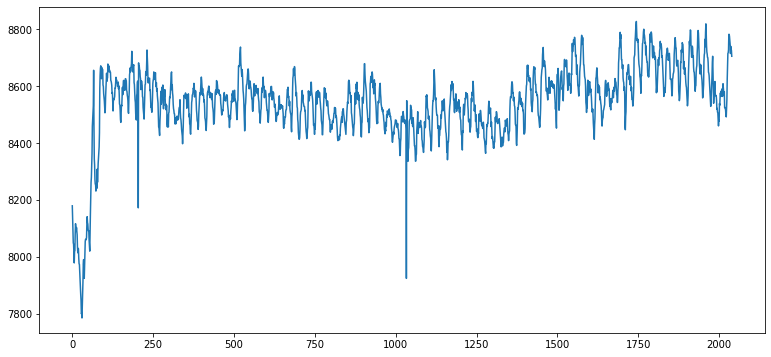

In [78]:
# 결측치 처리 로그 변환
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (13, 6)    # matlab 차트의 기본 크기를 13, 6으로 지정해주기

# 시계열(time series) 데이터를 차트로 그려 보기
plt.plot(ts)

In [79]:
# 결측치 처리 => 결측치가 없음
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: target, dtype: float64)

Series([], Name: target, dtype: float64)


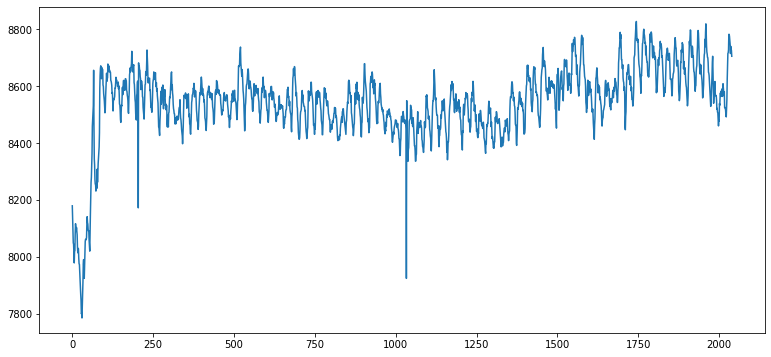

In [80]:
# 결측치가 있다면 이를 보간한다. 보간 기준은 time을 선택한다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인하기
print(ts[ts.isna()])

# 다시 그래프를 확인하기
plt.plot(ts)

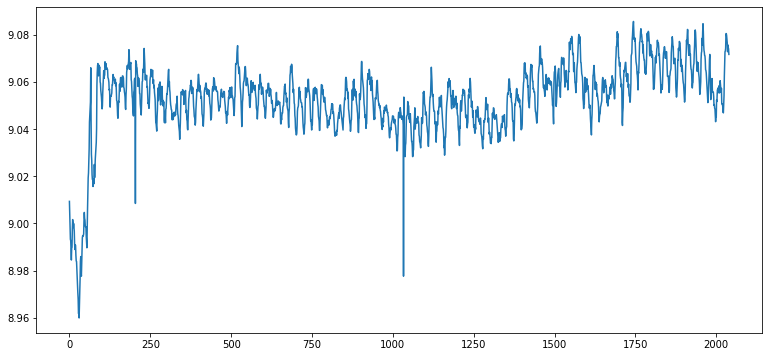

In [81]:
# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

# 로그 변환 전과 후 그래프 모양은 약간 평균에 좀 더 모여 있는 구조 같고,  y 축 값은 (0~17500) => (5~10)로 변환됨을 볼 수 있다.


정성적 그래프 분석 정량적 Augmented Dicky-Fuller Test 시계열 분해(Time Series Decomposition) Residual 안정성 확인

Moving average 제거 - 추세(Trend) 상쇄하기

시계열 분석에서 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 한다. 
이 변화량을 제거해 주기 위해 Moving Average, rolling mean을 구해서 ts_log에서 빼준다

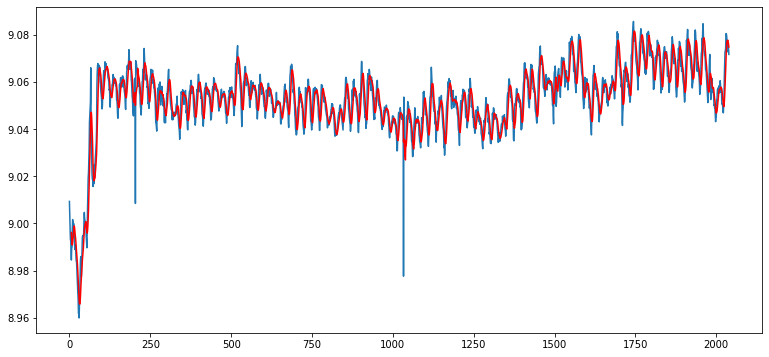

In [82]:
# 시계열 안정성 분석
moving_avg = ts_log.rolling(window=7).mean()  # moving average구하기, 7일 간격으로 이동평균을 구해 봄, 건물 사용이 평일, 휴일에 차이가 발생하므로
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [83]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(20)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6    -0.011640
7    -0.003713
8    -0.001442
9     0.006706
10    0.009595
11    0.007080
12    0.003767
13    0.003238
14    0.000247
15   -0.002186
16   -0.006760
17   -0.007289
18   -0.004019
19   -0.003100
Name: target, dtype: float64

Moving Average 계산 시 (windows size=7인 경우) 앞의 6개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생한다. 
이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시키므로 데이터셋에서 제거해 준다.

In [84]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

6    -0.011640
7    -0.003713
8    -0.001442
9     0.006706
10    0.009595
11    0.007080
12    0.003767
13    0.003238
14    0.000247
15   -0.002186
16   -0.006760
17   -0.007289
18   -0.004019
19   -0.003100
20   -0.005386
Name: target, dtype: float64

In [85]:
# 이동평균구하기
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


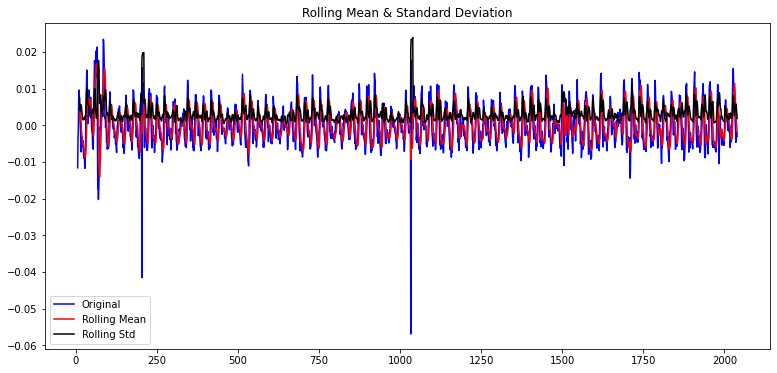

In [86]:
plot_rolling_statistics(ts_log_moving_avg)

In [87]:
# tatsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [88]:
augmented_dickey_fuller_test(ts_log_moving_avg)
# p-value가 0.00000 수준이 되었다. 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있다

Results of Dickey-Fuller Test:
Test Statistic                -8.476987e+00
p-value                        1.426596e-13
#Lags Used                     2.600000e+01
Number of Observations Used    2.007000e+03
Critical Value (1%)           -3.433612e+00
Critical Value (5%)           -2.862981e+00
Critical Value (10%)          -2.567537e+00
dtype: float64


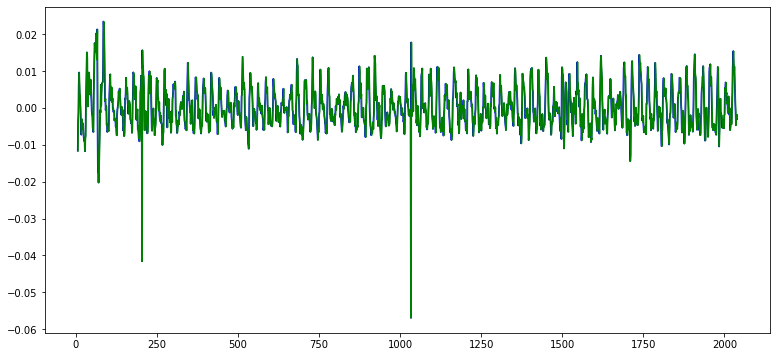

In [89]:
# 시프트한 시계열과 원본 시계열에 대한 그래프를 그려보기
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

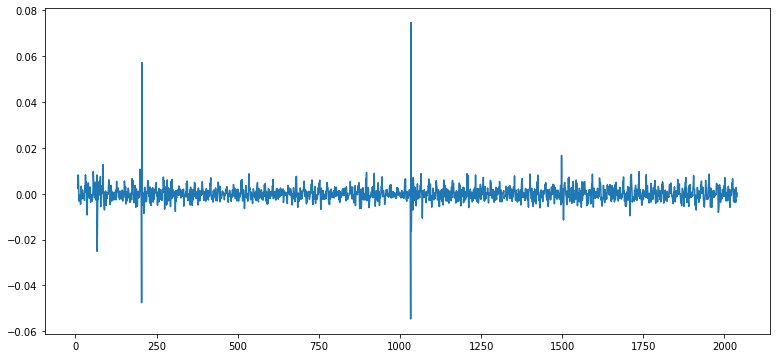

In [90]:
# 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

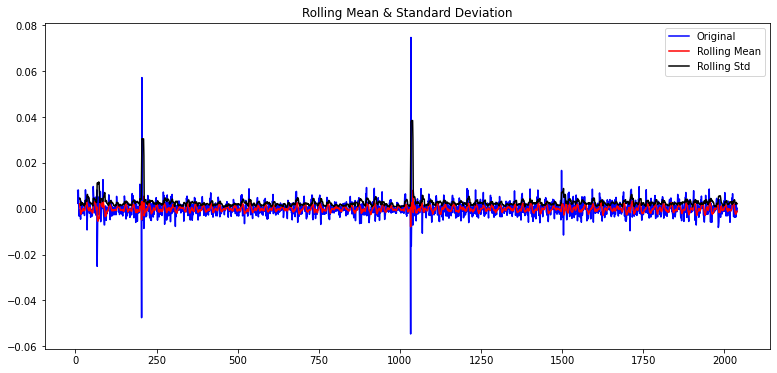

In [91]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악해보기
plot_rolling_statistics(ts_log_moving_avg_diff)

In [92]:
# 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행해 보기
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -27.054328
p-value                           0.000000
#Lags Used                       22.000000
Number of Observations Used    2010.000000
Critical Value (1%)              -3.433608
Critical Value (5%)              -2.862979
Critical Value (10%)             -2.567536
dtype: float64


이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과, 
p-value가 0.00000

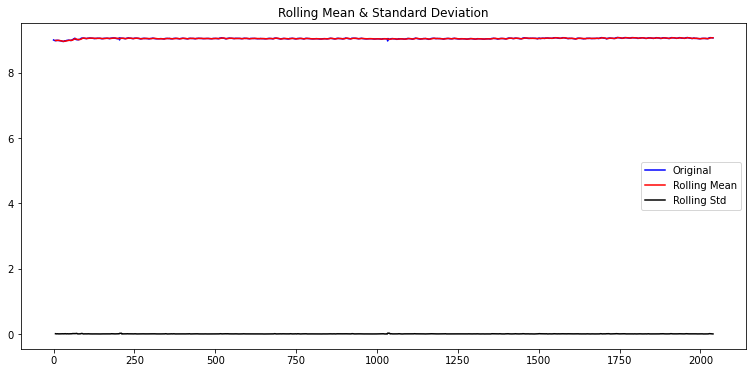

Results of Dickey-Fuller Test:
Test Statistic                -6.044942e+00
p-value                        1.318707e-07
#Lags Used                     2.600000e+01
Number of Observations Used    2.013000e+03
Critical Value (1%)           -3.433603e+00
Critical Value (5%)           -2.862977e+00
Critical Value (10%)          -2.567535e+00
dtype: float64


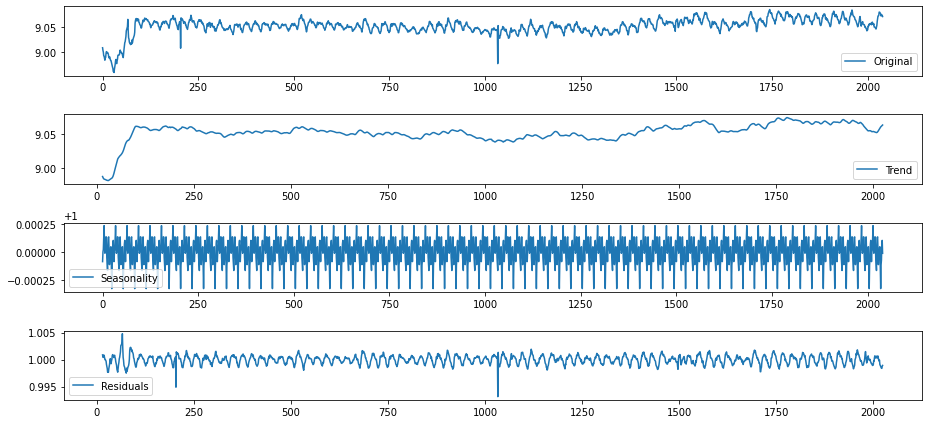

In [93]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=7)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

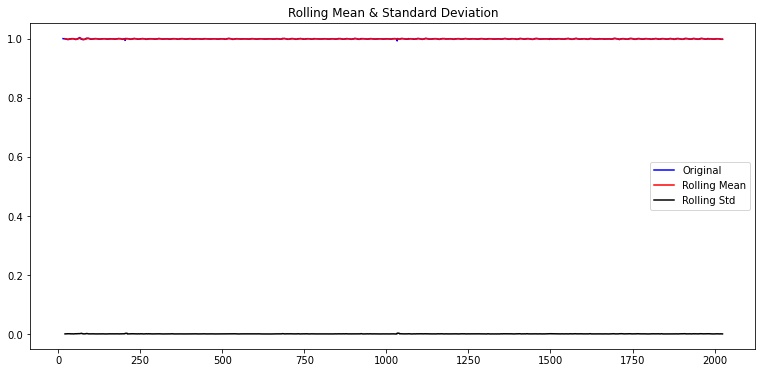

In [94]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

Decomposing을 통해 얻어진 Residual의 p-value : 1.318707e-07 < 0.05 이므로 귀무가설을 채택, 대립가설을 기각한다. 데이타 Residual의 안정성을 확인할 수 있다.

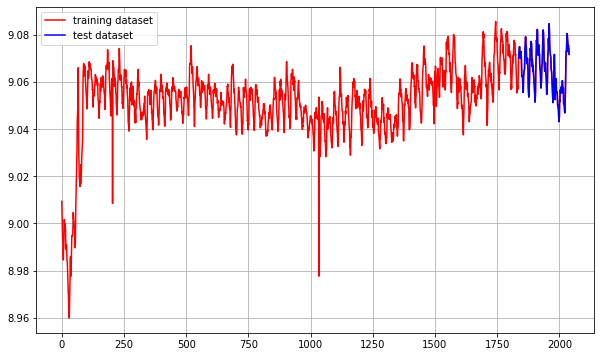

In [95]:
# 학습, 테스트 데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


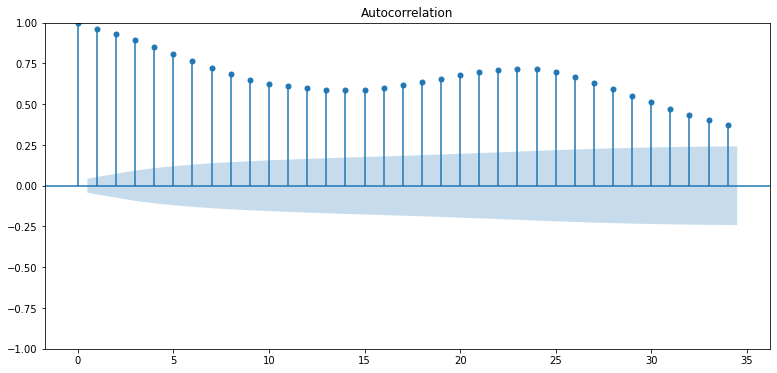

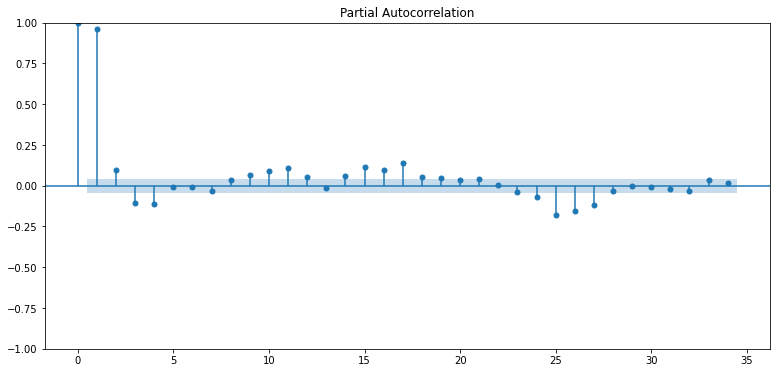

In [96]:
# 적정 ARIMA 모수 찾기 : ACF, PACF 그려보기 -> p,q 구하기 차분 안정성 확인 -> d 구하기
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 볼 때 p=1이 매우 적합한 것 같다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻이다.
ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다. q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다

Results of Dickey-Fuller Test:
Test Statistic                -8.965703e+00
p-value                        8.000352e-15
#Lags Used                     2.500000e+01
Number of Observations Used    2.013000e+03
Critical Value (1%)           -3.433603e+00
Critical Value (5%)           -2.862977e+00
Critical Value (10%)          -2.567535e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -25.321550
p-value                           0.000000
#Lags Used                       25.000000
Number of Observations Used    2012.000000
Critical Value (1%)              -3.433604
Critical Value (5%)              -2.862978
Critical Value (10%)             -2.567535
dtype: float64


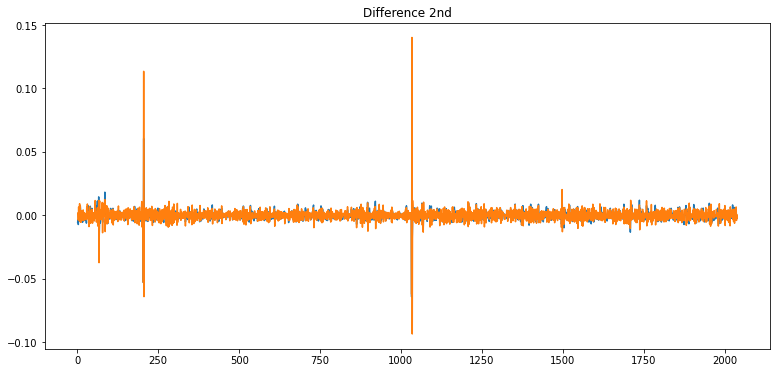

In [97]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분에서 p-value : 8.000352e-15 < 0.05, 2차 차분 결과 p-value : 0.00000 < 0.05를 보인 것으로 보아 확실히 안정화 상태라고 볼 수 있다.

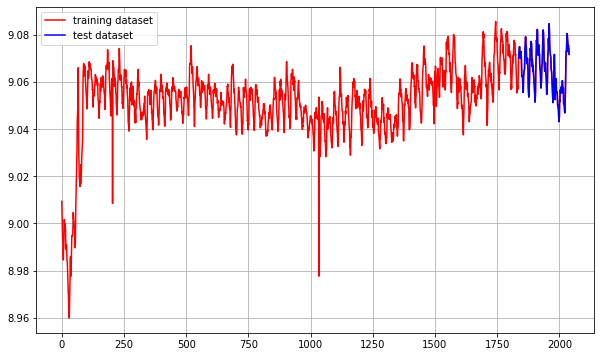

In [98]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [99]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

0    9.009332
1    9.004010
Name: target, dtype: float64
(1836,)
(204,)


In [100]:
# 최종 예측 모델 정확도 측정(MAPE)
# ARIMA 모델 훈련하기
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                 1836
Model:                 ARIMA(2, 1, 0)   Log Likelihood                7422.067
Date:                Tue, 08 Mar 2022   AIC                         -14838.133
Time:                        09:31:06   BIC                         -14821.589
Sample:                             0   HQIC                        -14832.032
                               - 1836                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1453      0.005    -30.646      0.000      -0.155      -0.136
ar.L2          0.0688      0.014      4.837      0.000       0.041       0.097
sigma2      1.795e-05   1.22e-07    147.342      0.0

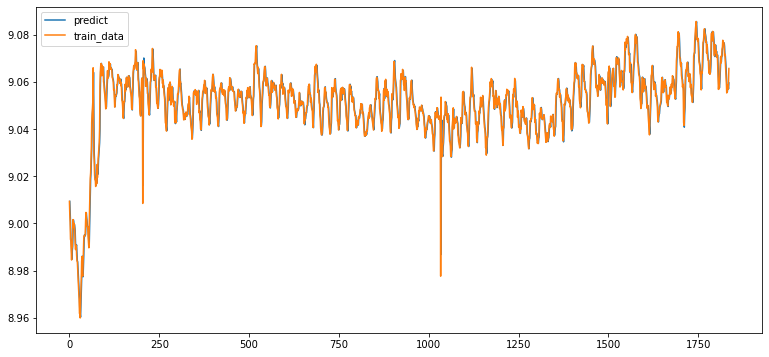

In [101]:
# ARIMA 모델이 훈련 결과를 시각적으로 확인하기
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

In [102]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                 1836
Model:                ARIMA(14, 1, 0)   Log Likelihood                7490.531
Date:                Tue, 08 Mar 2022   AIC                         -14951.063
Time:                        09:31:53   BIC                         -14868.341
Sample:                             0   HQIC                        -14920.557
                               - 1836                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2012      0.006    -35.839      0.000      -0.212      -0.190
ar.L2          0.0405      0.019      2.155      0.031       0.004       0.077
ar.L3          0.0540      0.022      2.465      0.0

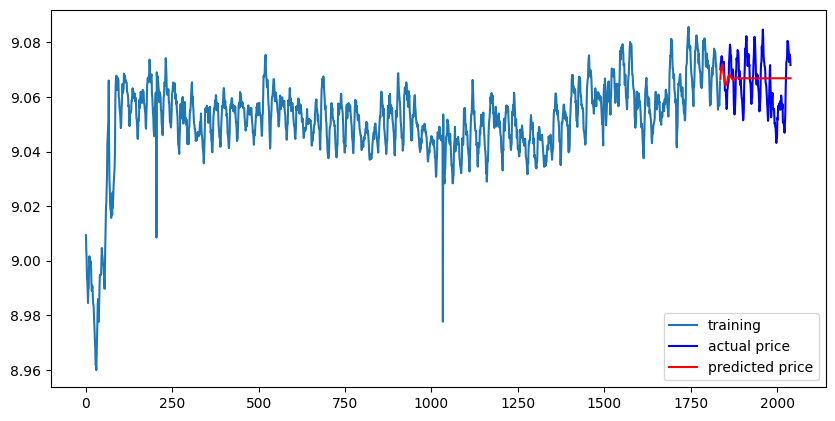

In [103]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  6509.082522738904
MAE:  67.08626270545854
RMSE:  80.678885234855
MAPE: 0.78%
